### **1、数据整理+数据特征挖掘**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotnine import *

#### **(1)数据导入**

In [2]:
# 读入数据，并指定时间标签
data = pd.read_csv('commodity.csv')
data.rename({'Unnamed: 0':'time'}, axis=1, inplace=True)
data = data.set_index('time')  # 设置索引
data.index = pd.to_datetime(data.index, format='%m/%Y') + pd.offsets.MonthEnd(0) # 将行索引格式转换为时间戳类型

# 读入商品累计值的数据，作相同的处理
data_cumu = pd.read_csv('commodity_cumu.csv')
data_cumu.rename({'Unnamed: 0':'time'}, axis=1, inplace=True)
data_cumu = data_cumu.set_index('time')  # 设置索引
data_cumu.index = pd.to_datetime(data_cumu.index, format='%m/%Y') + pd.offsets.MonthEnd(0)  # 将行索引格式转换为时间戳类型


In [3]:
# 从商品累计值的数据那里提取出来2月份的累计值
need = data_cumu[
    (data_cumu.index >= '2012-01-01') & 
    (data_cumu.index <= '2025-12-31') & 
    (data_cumu.index.month.isin([2]))
]

# 定义计算月度数据（按31/59和28/59比例拆分）的函数
def split_cumulative_to_monthly(cumulative_df):
    """
    将1-2月累计数据拆分为1月和2月月度数据
    
    参数:
    cumulative_df: DataFrame，索引为时间（datetime），有17个数值列
                 每行代表一年的1-2月累计值
    
    返回:
    DataFrame: 包含1月和2月月度数据，索引为月末日期
    """
    # 创建空列表存储结果
    monthly_rows = []
    
    # 比例系数
    jan_ratio = 31/59  # 1月占比
    feb_ratio = 28/59  # 2月占比
    
    for time_idx, row_series in cumulative_df.iterrows():
        year = time_idx.year
        month = time_idx.month
        day = time_idx.day
       
        # 计算1月数据
        jan_data = row_series * jan_ratio
        
        # 创建1月行 - 使用1月31日
        jan_row = jan_data.copy()
        jan_time = pd.Timestamp(f'{year}-01-31')
        
        # 创建结果字典
        jan_result = {'time': jan_time}
        for col in cumulative_df.columns:
            jan_result[col] = jan_row[col]
        
        monthly_rows.append(jan_result)
        
        # 计算2月数据
        feb_data = row_series * feb_ratio
        
        # 创建2月行 - 使用原始日期（2月最后一天）
        feb_row = feb_data.copy()
        if isinstance(time_idx, pd.Timestamp):
            feb_time = time_idx
        else:
            feb_time = pd.Timestamp(time_idx)
        
        feb_result = {'time': feb_time}
        for col in cumulative_df.columns:
            feb_result[col] = feb_row[col]
        
        monthly_rows.append(feb_result)
    
    # 创建结果DataFrame
    result_df = pd.DataFrame(monthly_rows)
    
    # 设置time列为索引
    result_df.set_index('time', inplace=True)
    
    # 按时间排序
    result_df.sort_index(inplace=True)
    
    return result_df

# 获得2012-2025年1-2月的月度数据
monthly_from_cumulative = split_cumulative_to_monthly(need)

In [4]:
data = pd.concat([data, monthly_from_cumulative])
data.sort_index(inplace=True)

#### **(2)数据的可视化分析：时序图**

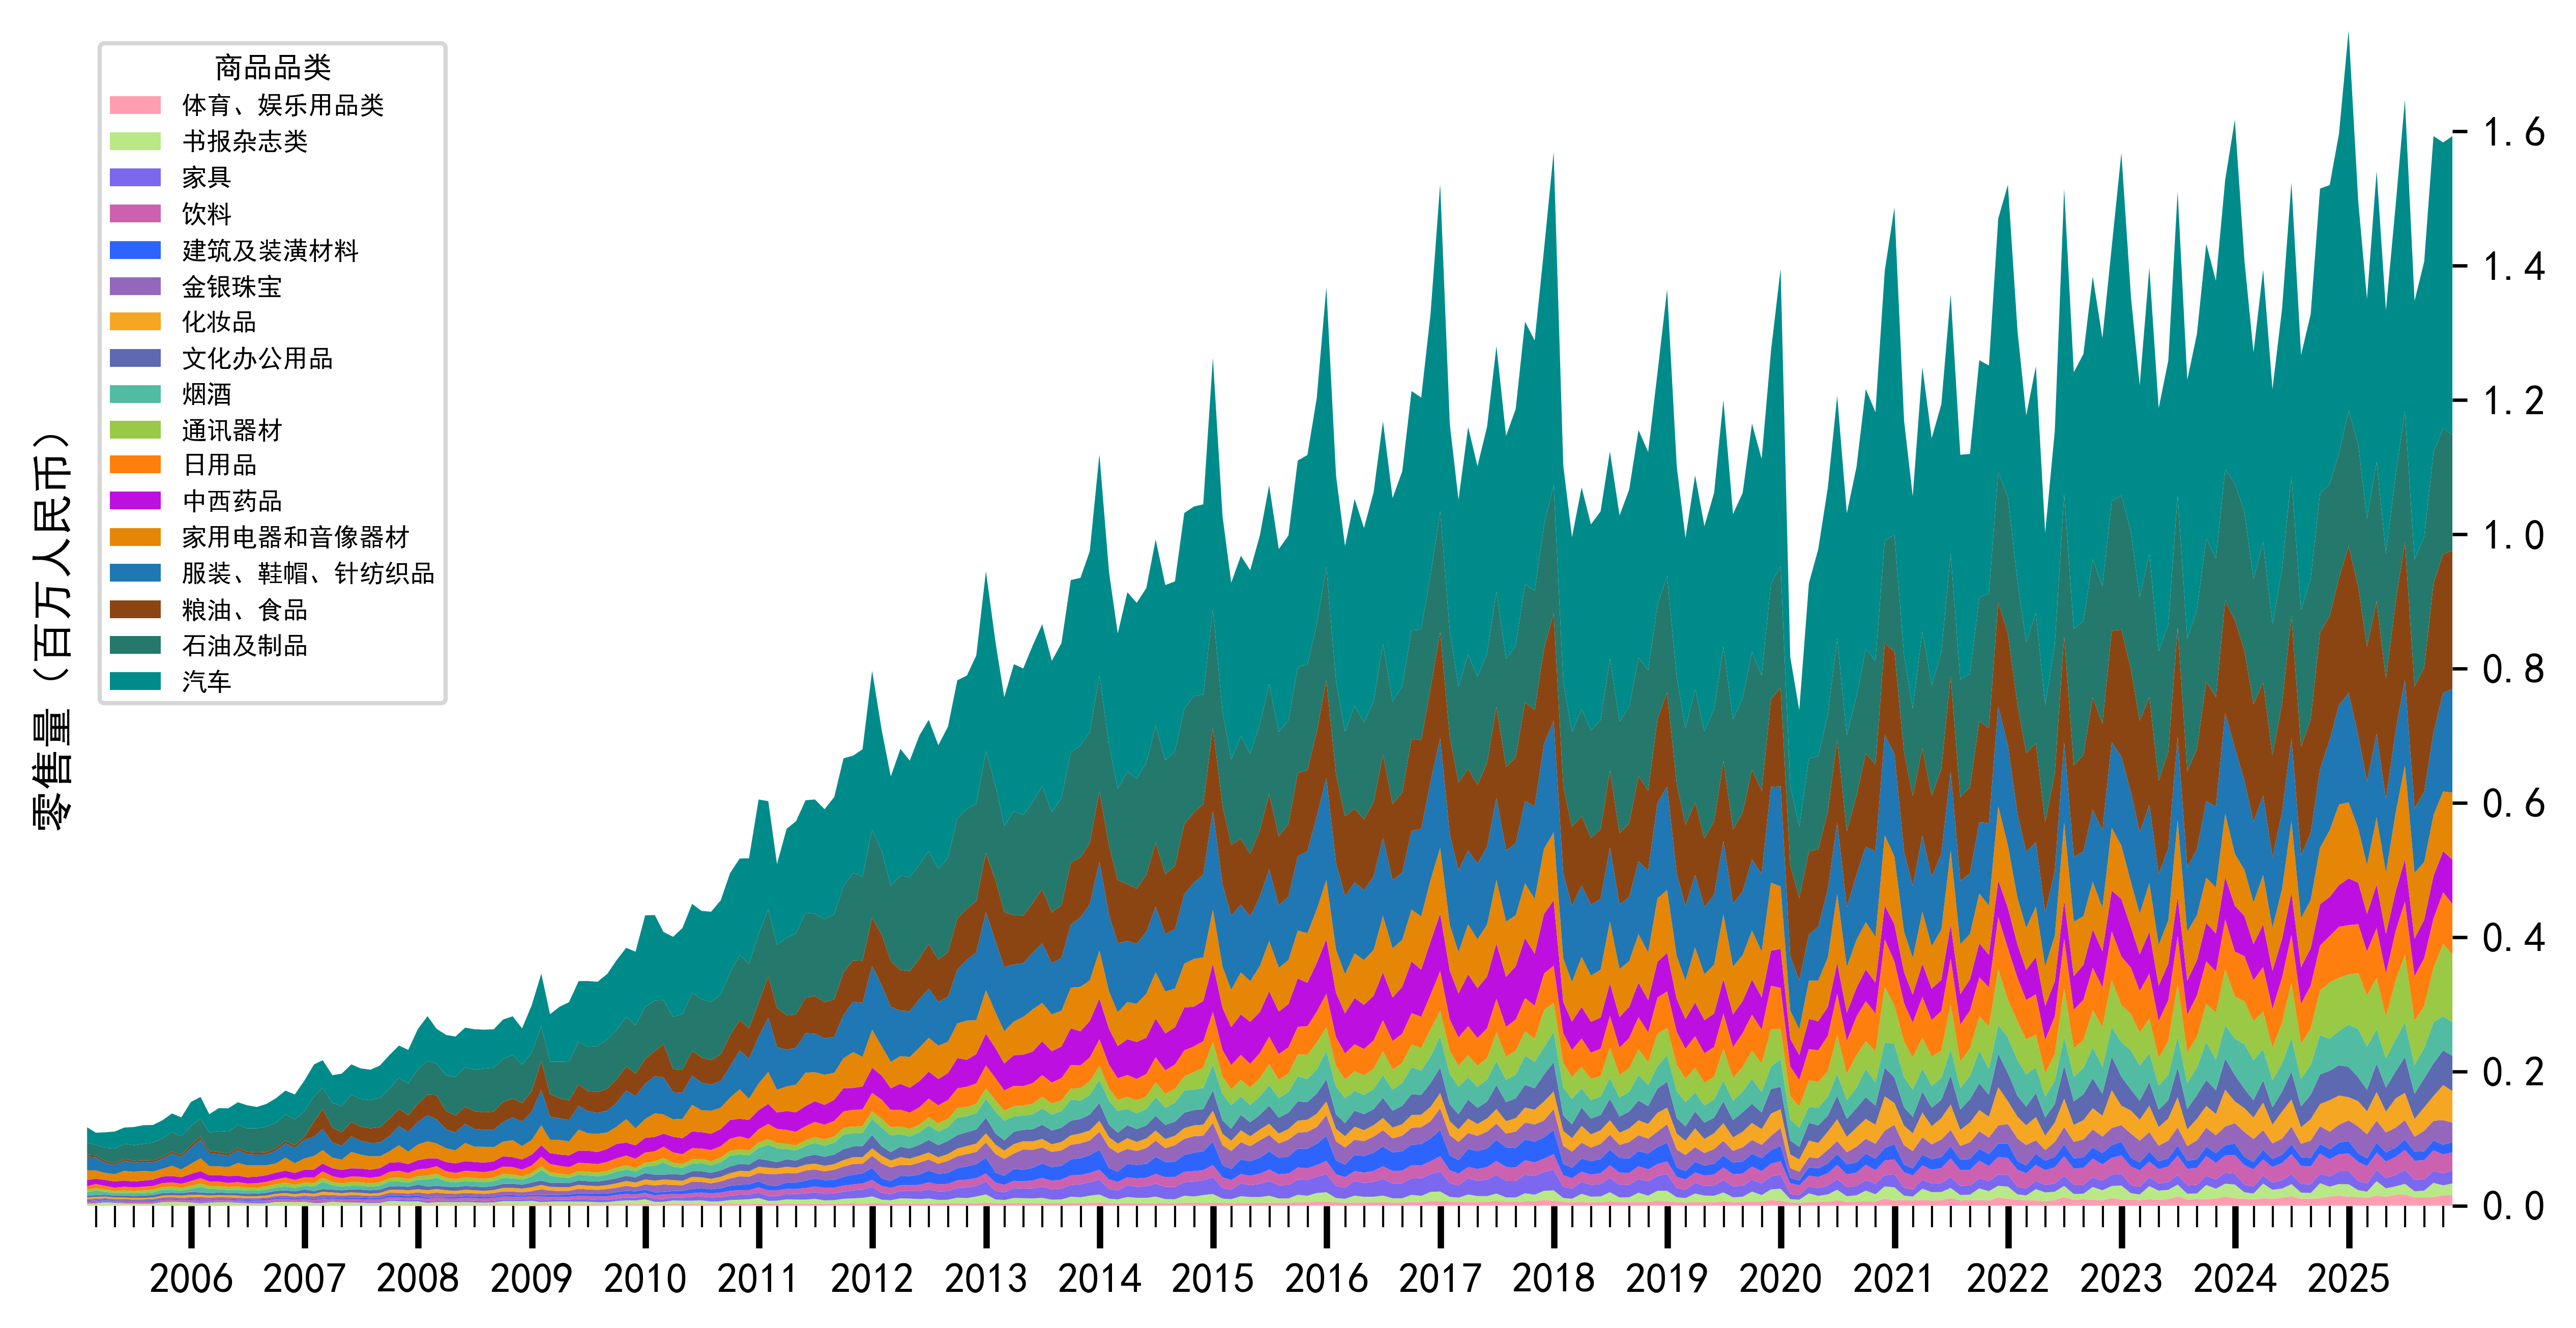

In [5]:
# 设置图像大小和图像分辨率
fig, ax = plt.subplots(figsize=(10,5), dpi=600)

# 设置颜色
color_palette = ['#FF9EB1', '#B8E986', '#7B68EE', '#CC61B0', '#2E64FE', 
                 '#9467BD', '#F5A623', '#5D69B1', '#52BCA3', '#99C945', 
                 '#FF7F0E', '#BD10E0', '#E58606', '#1F77B4', '#8B4513', 
                 '#24796C', '#008B8B']

plt.rcParams['font.sans-serif'] = ['SimHei']

# 设置标签
labels=['体育、娱乐用品类', '书报杂志类', '家具', '饮料', '建筑及装潢材料', '金银珠宝',
       '化妆品', '文化办公用品', '烟酒', '通讯器材', '日用品', '中西药品', '家用电器和音像器材',
       '服装、鞋帽、针纺织品', '粮油、食品', '石油及制品', '汽车']

# 使用stackplot()画堆叠面积图
ax.stackplot(
    data.index, data.qiuqi, data.shu, data.jiaju, data.yinliao,
    data.zhuangxiu, data.zhubao, data.huazhuang, data.wenju, data.yanjiu,
    data.tongxun, data.riyong, data.yaopin, data.jiadian,
    data.yifu, data.liangyou, data.shiyou, data.qiche,#设置横轴数据和多个纵轴数据序列参数的取值 
    colors=color_palette,  #设置堆叠面积图的颜色为'col_palette'
    zorder=2,  #设置堆叠面积图的绘制顺序为2，以覆盖其他元素
    labels=labels
);
# 让刻度以及刻度标签都贴紧图像
ax.margins(x=0, y=0)

# 隐藏图像的上下左右的边框线
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

#调整y轴的刻度以及刻度标签
ax.yaxis.tick_right()  #在右侧显示刻度与刻度标签

# 隐藏Y轴的指数标注
ax.yaxis.get_offset_text().set_visible(False)



# 设置主刻度（每年1月，显示年份）
ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 主刻度标签显示年份

# 设置次刻度（每月，仅显示刻度线，不显示标签）
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))  # 每月一个次刻度

# 美化：主刻度线更粗，次刻度线更细
ax.tick_params(axis='x', which='major', length=10, width=1.5)  # 主刻度线
ax.tick_params(axis='x', which='minor', length=5, width=0.5)   # 次刻度线



ax.legend(
    loc='upper left',  # 图例位置（可选：'upper right'/'lower left'/'best'等）
    bbox_to_anchor=(0, 1),  # 图例超出图框，避免遮挡图像（适合标签多的场景）
    fontsize=6,  # 图例字体大小
    title='商品品类',  # 图例标题
    title_fontsize=7  # 图例标题字体大小
)

ax.set_ylabel("零售量（百万人民币）", fontsize=10)

plt.savefig("2005-2025商品零售量的月度时序图.png", dpi=600)

#### **(3)数据特征挖掘：数据的探索性分析+时间序列分析**

**定义时间序列类别**

In [6]:
class TimeSeries:
    '''
    时间序列类
    包含时间序列的基本属性和常用操作方法
    基本属性：cumulative_growth累计增长量（当期值-基期值）；average_growth_rate平均增长率=（末期值/初期值）^ (1/T)
    常用操作方法：ADF_test时间序列的平稳性检验；season_type测量时间序列季节波动的幅度与时间是否有关系；
                Seasonal_decompose采用简单移动平均来提取季节效应；X11_seasonal_decompose采用X11模型来提取季节效应
                holt_winters对时间序列进行Holt-Winters三参数指数平滑模型拟合
                change衡量基于简单移动平均的因素分解与X11模型的因素分解的差别，具体来说是计算两种分解方法提取出来的季节效应的欧式距离
    '''

    # 构造函数：初始化实例属性
    def __init__(self, ts_data):
        '''
        ts_data是一个series，指标是时间
        '''
        # 检查是否为pandas Series
        if not isinstance(ts_data, pd.Series):
            raise TypeError(f"输入必须是pandas Series，但得到的是 {type(ts_data).__name__}")
        
        # 检查索引是否为datetime类型
        if not isinstance(ts_data.index, pd.DatetimeIndex):
            # 尝试转换索引
            try:
                ts_data.index = pd.to_datetime(ts_data.index)
            except (ValueError, TypeError) as e:
                raise TypeError(f"Series索引必须为datetime类型，转换失败: {e}")
        
        self.ts_data = ts_data  
        
        self.values = ts_data.values
        self.name = ts_data.name
    
    # 时间序列的基本指标
    # 定义累计增长量函数
    def cumulative_growth(self):
        '''
        累计增长量=当期值-基期值
        '''
        growth = self.values[len(self.values) - 1] - self.values[0]
        self.growth = growth
        return self.growth
    # 定义平均增长率函数
    def average_growth_rate(self):
        '''
        平均增长率=（末期值/初期值）^ (1/T)
        '''
        g = (self.values[len(self.values) - 1] / self.values[0]) ** (1 / len(self.values))
        g_rate = g - 1
        self.g_rate = g_rate
        return self.g_rate

    # 对数据进行平稳性检验
    def ADF_test(self):
        '''
        函数返回值是True，意味原假设正确，该时间序列非平稳
        '''
        # 导入进行ADF检验的adfuller函数
        from statsmodels.tsa.api import adfuller  
        self.P_value = adfuller(self.ts_data)[1]
        if self.P_value > 0.1:  # 当p大于0.1时，认为可以“接受原假设”
            return True
        elif self.P_value < 0.05:  # 选择0.05的显著性水平
            return False

    # 对时间序列数据进行确定性因素分解
    # 测量时间序列季节波动的幅度与时间是否有关系
    def season_type(self):
        a = pd.DataFrame(self.ts_data)
        a['year'] = a.index.year
        Range = a.groupby(['year'])[self.name].aggregate(['min', 'max'])
        Range['range'] = Range['max'] - Range['min']
        Range['year'] = Range.index
        corr = Range['range'].corr(Range['year'])
        if abs(corr) > 0.65:  # 当相关系数的绝对值大于0.75时，认为季节性波动与长期趋势相关
            return 'multiplicative'
        else:
            return 'additive'
    # 采用简单移动平均来提取季节效应
    def Seasonal_decompose(self):
        a = pd.DataFrame(self.ts_data)
        # 做12期中心移动平均
        a['m12'] = a[self.name].rolling(12, center=True).mean().shift(-1)
        # 做2*12复合移动平均
        a['m2_12'] = a.m12.rolling(2, center=True).mean()
        # 计算去除趋势后的序列
        if self.season_type() == 'multiplicative':
            a['number_t'] = a[self.name] / a['m2_12']
            # 提取季节效应
            # 计算月度均值
            a['month'] = a.index.month
            mean_month = a.groupby('month')['number_t'].mean()
            # 计算总均值
            mean_all = a.number_t.mean()
            # 计算季节指数（乘法模型季节指数=季节均值（月度均值）/总均值）
            index_season = mean_month / mean_all
            return index_season

        elif self.season_type() == 'additive':
            a['number_t'] = a[self.name] - a['m2_12']
            # 提取季节效应
            # 计算月度均值
            a['month'] = a.index.month
            mean_month = a.groupby('month')['number_t'].mean()
            # 计算总均值
            mean_all = a.number_t.mean()
            # 计算季节指数（加法模型季节指数=季节均值（月度均值）-总均值）
            index_season = mean_month - mean_all
            return index_season
    # 采用X11模型来提取季节效应    
    def X11_seasonal_decompose(self):
        # 导入seasonal_decompose函数
        from statsmodels.tsa.api import seasonal_decompose
        # 对序列进行乘法模型的因素分解
        decompose = seasonal_decompose(self.ts_data, period=12, 
                                       model=self.season_type())
        a = pd.Series(decompose.seasonal.head(12))
        a.index = a.index.month
        a.index.name = 'month'
        return a

    def X11_trend_decompose(self):
        # 导入seasonal_decompose函数
        from statsmodels.tsa.api import seasonal_decompose
        # 对序列进行乘法模型的因素分解
        decompose = seasonal_decompose(self.ts_data, period=12, 
                                       model=self.season_type())

        trend = decompose.trend
       
        return trend

    
    # 对时间序列进行Holt-Winters三参数指数平滑模型拟合
    def holt_winters(self):
        # 导入ExponentialSmoothing函数
        from statsmodels.tsa.api import ExponentialSmoothing
        from warnings import filterwarnings
        filterwarnings('ignore')	
        # 进行模型拟合
        fit_number = ExponentialSmoothing(self.ts_data, trend=self.season_type()[0: 3],
                                          seasonal=self.season_type()[0: 3], seasonal_periods=12).fit()
        self.hwlevel = fit_number.params["smoothing_level"]
        self.hwtrend = fit_number.params["smoothing_trend"]
        self.hwseasonal = fit_number.params["smoothing_seasonal"]

    def change(self):
        '''
        衡量基于简单移动平均的因素分解与X11模型的因素分解的差别，具体来说就是计算两种分解方法提取出来的季节效应的欧式距离
        '''
        a = np.array(self.X11_seasonal_decompose())
        b = np.array(self.Seasonal_decompose())
        d = a - b
        factor = np.sqrt(np.dot(a, a.T) * np.dot(b, b.T))
        # 避免两个模型计算出来的季节指数为零时，引发除零的异常
        try:
            difference = np.dot(d, d.T) / factor
        except ZeroDivisionError as e:
            difference = 0
        return difference 

**代入数据提取特征**

In [7]:
# 创建一个字典，键对应的是商品名，值对应的是该商品类型为时间序列的数据
n_type = data.shape[1]
data_dict = {}
data_columns = list(data.columns)
for i in range(n_type):
    data_dict[f"{data_columns[i]}"] = TimeSeries(data.iloc[:,i])

# 创建一个空数据框用来储存提取的商品零售特征
df = pd.DataFrame(index=data_columns)

In [8]:
# 提取特征：累计增长量、平均增长率、平稳（1代表非平稳）、两种因素分解模型计算的12个月份的季节指数及两种模型之间的差距、
# Holt-Winters三参数指数模型的三个平滑系数
cumulative_growths = []
average_growth_rates = []
stationary = []
seasonal_smv = {}
seasonal_X11 = {}
hwlevel = []
hwtrend = []
hwseasonal = []
change = []
for i in range(12):
    seasonal_smv[f"{i}"] = []
for i in range(12):
    seasonal_X11[f"{i}"] = []

for i in data_dict:
    # 获得17种商品类别的累计增长量和平均增长率
    cumulative_growths.append(data_dict[i].cumulative_growth())
    average_growth_rates.append(data_dict[i].average_growth_rate())
    # 获得17种商品类别的平稳性检验结果
    stationary.append(int(data_dict[i].ADF_test()))
    # 获得17种商品类别的简单移动平均计算的季节指数
    for j in range(12):
        seasonal_smv[f"{j}"].append(data_dict[i].Seasonal_decompose().values[j])
    # 获得17种商品类别的X11模型计算的季节指数
    for j in range(12):
        seasonal_X11[f"{j}"].append(data_dict[i].X11_seasonal_decompose().values[j])
    # 获得时间序列有关Holt-Winters三参数指数平滑模型的有关参数
    data_dict[i].holt_winters()
    # 获得17种商品类别的水平平滑参数
    hwlevel.append(data_dict[i].hwlevel)
    # 获得17种商品类别的季节项平滑参数
    hwseasonal.append(data_dict[i].hwseasonal)
    # 获得17种商品类别的趋势项平滑参数
    hwtrend.append(data_dict[i].hwtrend)
    # 获得17种商品类别的两种因素分解模型的差距
    change.append(data_dict[i].change())
   
    
    
df['cumulative_growth'] = cumulative_growths
df['average_growth_rate'] = average_growth_rates
df['stationary'] = stationary
for i in range(12):
    df[f"seasonal_smv{i}"] = seasonal_smv[f"{i}"]
    df[f"seasonal_X11{i}"] = seasonal_X11[f"{i}"]
df['hwlevel'] = hwlevel
df['hwseasonal'] = hwseasonal
df['hwtrend'] = hwtrend
df['change'] = change

### **2、对商品种类进行聚类分析**

#### **(1)层次聚类分析**

In [9]:
# 1、导入需要的包
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# 2、特征标准化（关键步骤：消除量纲影响）
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df)

# 获得17种商品类别的季节效应类型：乘法模型记为1，加法模型记为0 并加到特征矩阵中
seasonal_type = []
for i in data_dict:
    if data_dict[i].season_type() == 'multiplicative':
        seasonal_type.append(1)
    else:
        seasonal_type.append(0)
seasonal_type = np.array(seasonal_type)
seasonal_type = seasonal_type[:, np.newaxis]
features_scaled = np.hstack([features_scaled, seasonal_type])

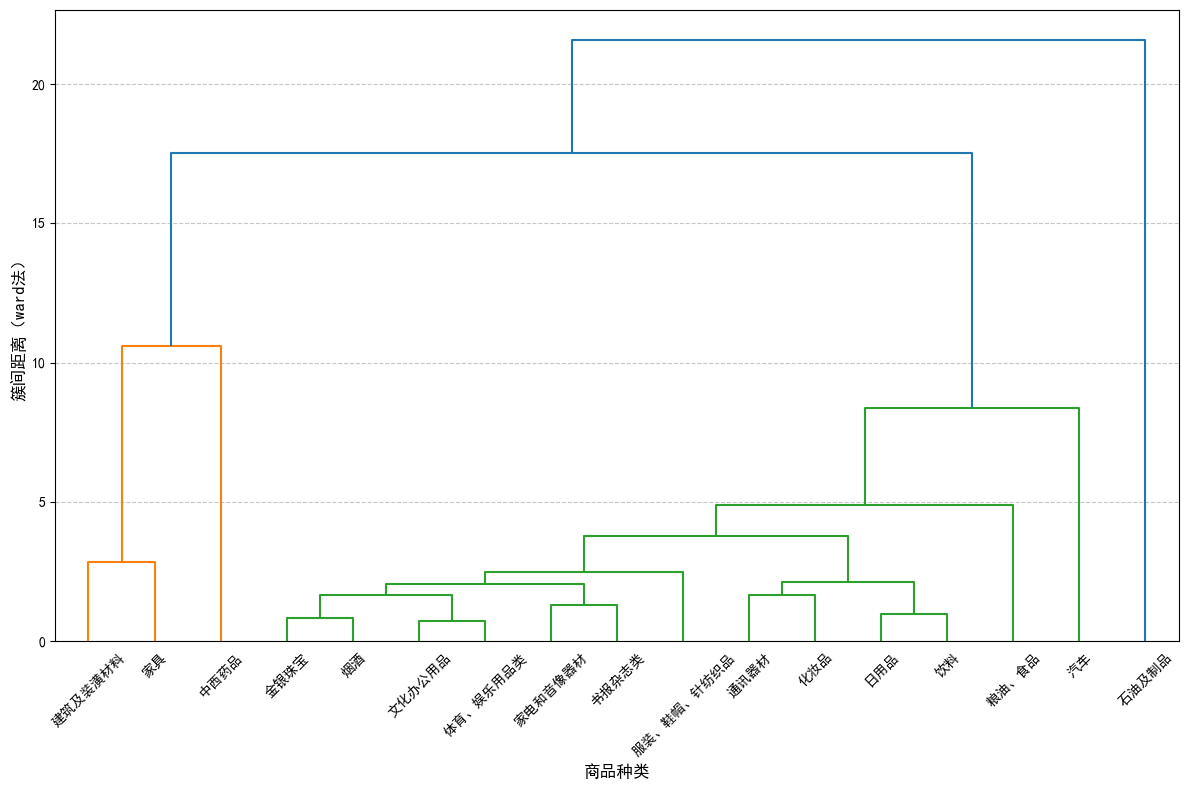

In [10]:
# 3、执行层次聚类（核心函数：linkage）
# linkage函数：生成聚类的层次结构（簇间距离矩阵）
# 关键参数说明：
# - y：标准化后的特征矩阵（或样本间距离矩阵）
# - method：簇的链接方式（推荐ward法，最小化簇内方差，适配数值型特征）
# - metric：样本间距离度量（推荐euclidean欧氏距离，适配连续特征）
cluster_linkage = linkage(
    y=features_scaled,
    method='ward',  # 可选：single（最近邻）、complete（最远邻）、average（平均距离）、ward（最优，优先选）
    metric='euclidean'  # 可选：euclidean（欧氏距离）、cosine（余弦距离，高维数据也适用）、manhattan（曼哈顿距离）
)

# 4、可视化聚类树（树状图，核心函数：dendrogram）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.figure(figsize=(12, 8));  # 设置图大小

# 定义商品标签
good_name = ['烟酒', '粮油、食品', '饮料', '化妆品', '金银珠宝', '体育、娱乐用品类', 
            '书报杂志类', '家电和音像器材', '文化办公用品', '通讯器材', '家具',
            '日用品', '中西药品', '石油及制品', '建筑及装潢材料', '汽车', '服装、鞋帽、针纺织品']

# dendrogram函数：绘制树状图，直观展示聚类层级
dendrogram(
    Z=cluster_linkage,  # linkage输出的聚类结构
    labels=good_name,    # 样本标签（商品名称，便于识别）
    orientation='top',  # 树状图方向（top/left/right/bottom）
    distance_sort='descending',  # 按距离降序排列
    show_leaf_counts=True,       # 显示叶节点数量
    leaf_font_size=10,           # 叶节点（商品名）字体大小
    leaf_rotation=45             # 商品名旋转角度，避免重叠
);


plt.xlabel('商品种类', fontsize=12);
plt.ylabel('簇间距离（ward法）', fontsize=12);
plt.grid(axis='y', linestyle='--', alpha=0.7);
plt.tight_layout(); # 自动调整布局
plt.savefig("商品种类层次聚类树状图.png", dpi=300);
plt.show();

In [11]:
# 5、确定最终聚类结果（核心函数：fcluster）
# fcluster函数：根据树状图，按指定规则划分簇
# 关键参数说明：
# - Z：linkage输出的聚类结构
# - t：簇的划分阈值（可通过树状图的纵向距离确定，或指定簇数）
# - criterion：划分规则（'maxclust'=指定簇数；'distance'=指定距离阈值）
# 方式：指定簇数
n_clusters = 3
cluster_labels1 = fcluster(
    Z=cluster_linkage,
    t=n_clusters,
    criterion='maxclust'  # 按簇数划分
)

# 6、整理聚类结果
df['聚类标签'] = cluster_labels1
print("商品种类层次聚类结果：")
print(df[['聚类标签']])  # 展示每个商品对应的簇标签
print(f"\n最终聚类数量：{n_clusters}")
print(f"\n各簇商品数量：")
print(df['聚类标签'].value_counts().sort_index())

商品种类层次聚类结果：
           聚类标签
yanjiu        1
liangyou      1
yinliao       1
huazhuang     1
zhubao        1
qiuqi         1
shu           1
jiadian       1
wenju         1
tongxun       1
jiaju         2
riyong        1
yaopin        2
shiyou        3
zhuangxiu     2
qiche         1
yifu          1

最终聚类数量：3

各簇商品数量：
聚类标签
1    13
2     3
3     1
Name: count, dtype: int64


#### **(2)K-means交叉验证**

In [12]:
# 1、导入包
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import LeaveOneOut

# 2、选择待验证的簇数K（比如K=3）
k = 5

# 3、初始化留一法交叉验证
loo = LeaveOneOut()
sil_scores = []  # 存储每折的轮廓系数

# 4、迭代训练
for train_idx, val_idx in loo.split(features_scaled):
    X_train, X_val = features_scaled[train_idx], features_scaled[val_idx]
    
    # 用训练集训练K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    # 合并训练集和验证集，计算整体轮廓系数（评估一致性）
    X_combined = np.vstack([X_train, X_val])
    labels_combined = np.hstack([kmeans.labels_, kmeans.predict(X_val)])
    sil_score = silhouette_score(X_combined, labels_combined)
    sil_scores.append(sil_score)

# 5、结果分析
mean_sil = np.mean(sil_scores)
std_sil = np.std(sil_scores)
print(f"簇数K={k}时，交叉验证轮廓系数均值：{mean_sil:.3f}，标准差：{std_sil:.3f}")

簇数K=5时，交叉验证轮廓系数均值：0.500，标准差：0.062


#### **(3)DBSCAN聚类**

In [13]:
from sklearn.cluster import DBSCAN

# 1、执行DBSCAN聚类（核心函数：DBSCAN）
# 关键参数说明：
# - eps：邻域半径（样本距离≤eps视为邻域内样本，需根据数据调整）
# - min_samples：核心点判定阈值（邻域内样本数≥min_samples为核心点，样本量17建议设2-4）
# - metric：距离度量方式（默认euclidean欧氏距离，高维数据可尝试cosine余弦距离）
# - n_jobs：并行计算核心数（-1表示使用所有CPU核心）
dbscan = DBSCAN(
    eps=4,  # 邻域半径，可通过K近邻图确定（后续有调整方法）
    min_samples=2,  # 核心点最小样本数，适配17个商品的小样本场景
    metric='euclidean',  # 距离度量：euclidean/cosine/manhattan
    n_jobs=-1
)
# 训练模型并获取聚类标签（-1表示噪声点）
cluster_labels = dbscan.fit_predict(features_scaled)
#2、整理聚类结果
df['聚类标签'] = cluster_labels
# 统计结果
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # 排除噪声点后的簇数
n_noise = list(cluster_labels).count(-1)  # 噪声点数量

print("="*50)
print("商品种类DBSCAN聚类结果汇总")
print("="*50)
print(f"最终聚类数量：{n_clusters}")
print(f"噪声点数量：{n_noise}")
print("\n各簇商品数量分布：")
print(df['聚类标签'].value_counts().sort_index())
print("\n详细聚类结果（商品-聚类标签）：")
print(df[['聚类标签']])

商品种类DBSCAN聚类结果汇总
最终聚类数量：2
噪声点数量：3

各簇商品数量分布：
聚类标签
-1     3
 0    12
 1     2
Name: count, dtype: int64

详细聚类结果（商品-聚类标签）：
           聚类标签
yanjiu        0
liangyou      0
yinliao       0
huazhuang     0
zhubao        0
qiuqi         0
shu           0
jiadian       0
wenju         0
tongxun       0
jiaju         1
riyong        0
yaopin       -1
shiyou       -1
zhuangxiu     1
qiche        -1
yifu          0



eps参数调整参考（K近邻距离图）


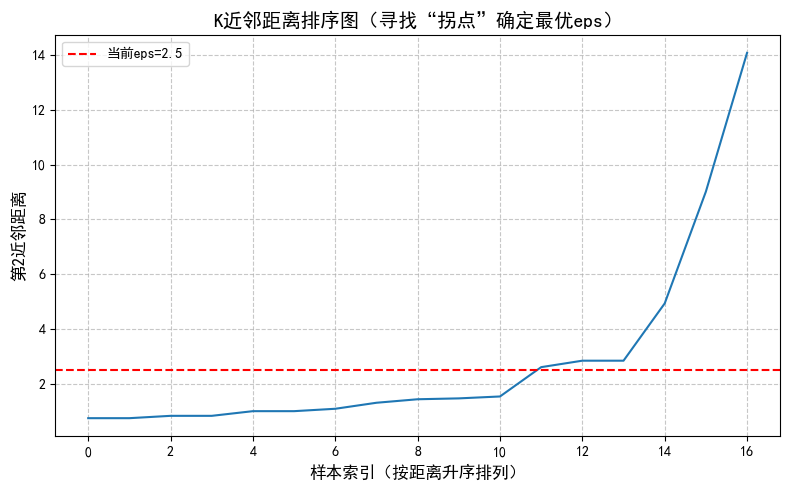

提示：图中曲线的“拐点”对应的距离即为最优eps值，可据此调整参数


In [14]:
# 3、eps参数调整方法（通过K近邻图确定最优eps）
print("\n" + "="*50)
print("eps参数调整参考（K近邻距离图）")
print("="*50)
from sklearn.neighbors import NearestNeighbors
# 计算每个样本的k近邻距离（k=min_samples-1=2）
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_scaled)
distances, indices = nbrs.kneighbors(features_scaled)
# 按距离升序排序
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # 取第2近邻的距离（第0列是自身距离0）
# 绘制K近邻距离图
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K近邻距离排序图（寻找“拐点”确定最优eps）', fontsize=14)
plt.xlabel('样本索引（按距离升序排列）', fontsize=12)
plt.ylabel('第2近邻距离', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.axhline(y=2.5, color='r', linestyle='--', label=f'当前eps=2.5')
plt.legend()
plt.tight_layout()
plt.show()
print("提示：图中曲线的“拐点”对应的距离即为最优eps值，可据此调整参数")

#### **(4)GMM聚类**

通过BIC/AIC准则寻找最优簇数


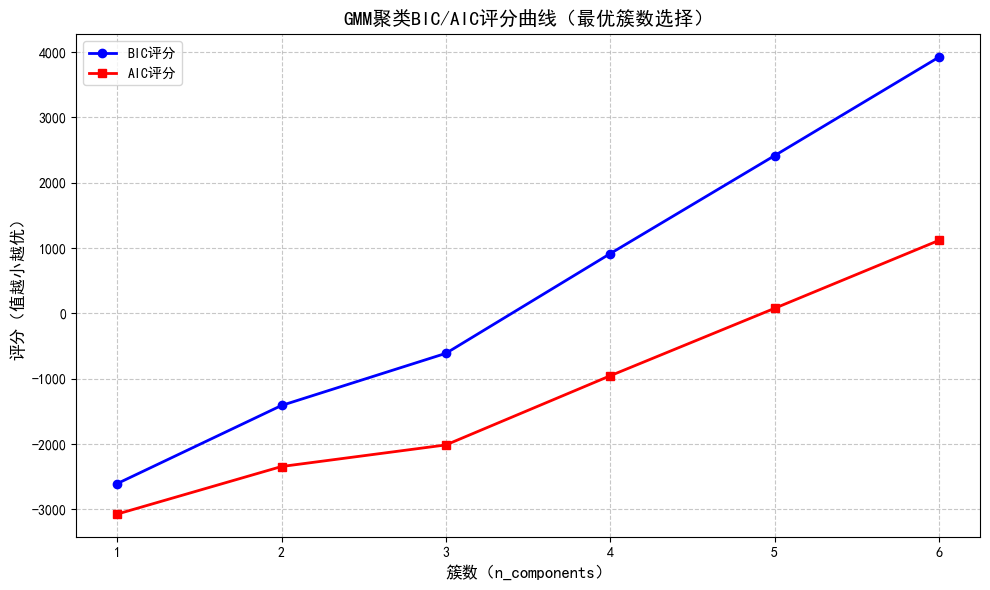


基于BIC准则的最优簇数：1
各簇数对应的BIC评分：{1: np.float64(-2603.804277920868), 2: np.float64(-1408.368436252396), 3: np.float64(-610.5975952722702), 4: np.float64(915.2286386241949), 5: np.float64(2414.1501508302954), 6: np.float64(3921.278949224432)}

商品种类GMM聚类结果汇总
最终聚类数量：1

各簇商品数量分布：
聚类标签
0    13
1     1
2     3
Name: count, dtype: int64

详细聚类结果（商品-聚类标签-归属概率）：
           聚类标签  归属概率
yanjiu        0   1.0
liangyou      0   1.0
yinliao       0   1.0
huazhuang     0   1.0
zhubao        0   1.0
qiuqi         0   1.0
shu           0   1.0
jiadian       0   1.0
wenju         0   1.0
tongxun       0   1.0
jiaju         2   1.0
riyong        0   1.0
yaopin        2   1.0
shiyou        1   1.0
zhuangxiu     2   1.0
qiche         0   1.0
yifu          0   1.0


In [15]:
from sklearn.mixture import GaussianMixture

# 1、选择最优簇数（通过BIC/ AIC准则，避免手动指定簇数的主观性）
print("="*50)
print("通过BIC/AIC准则寻找最优簇数")
print("="*50)
# 尝试簇数范围（17个样本，簇数建议1-6）
n_components_range = range(1, 7)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='full',  # 协方差类型，后续详解
        random_state=42
    )
    gmm.fit(features_scaled)
    bic_scores.append(gmm.bic(features_scaled))  # BIC评分（值越小，模型越优）
    aic_scores.append(gmm.aic(features_scaled))  # AIC评分（值越小，模型越优）

# 可视化BIC/AIC曲线
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, 'o-', label='BIC评分', color='blue', linewidth=2)
plt.plot(n_components_range, aic_scores, 's-', label='AIC评分', color='red', linewidth=2)
plt.xlabel('簇数（n_components）', fontsize=12)
plt.ylabel('评分（值越小越优）', fontsize=12)
plt.title('GMM聚类BIC/AIC评分曲线（最优簇数选择）', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(n_components_range)
plt.tight_layout()
plt.show()

# 确定最优簇数（BIC评分最小值对应的簇数，若有平缓拐点，选拐点处簇数）
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"\n基于BIC准则的最优簇数：{optimal_n_components}")
print(f"各簇数对应的BIC评分：{dict(zip(n_components_range, bic_scores))}")

# 2、执行GMM聚类（使用最优簇数）
gmm = GaussianMixture(
    n_components=3,  # 簇数（最优簇数optimal_n_components）
    covariance_type='full',  # 协方差类型：full/ tied/ diag/ spherical
    random_state=42,  # 固定随机种子，结果可复现
    max_iter=1000,  # 最大迭代次数，确保模型收敛
    n_init=10  # 多次初始化，避免局部最优
)

# 训练模型并获取结果
gmm.fit(features_scaled)
# 硬聚类标签（每个样本最可能归属的簇）
cluster_labels = gmm.predict(features_scaled)
# 软聚类概率（每个样本属于各簇的概率，形状：17×optimal_n_components）
cluster_probs = gmm.predict_proba(features_scaled)

# 3、整理聚类结果
df['聚类标签'] = cluster_labels
# 为每个商品添加“归属概率”（对应其最可能簇的概率）
df['归属概率'] = [cluster_probs[i, label] for i, label in enumerate(cluster_labels)]

# 统计结果
print("\n" + "="*50)
print("商品种类GMM聚类结果汇总")
print("="*50)
print(f"最终聚类数量：{optimal_n_components}")
print("\n各簇商品数量分布：")
cluster_count = df['聚类标签'].value_counts().sort_index()
print(cluster_count)
print("\n详细聚类结果（商品-聚类标签-归属概率）：")
print(df[['聚类标签', '归属概率']].round(3))  # 保留3位小数

#### **(5)对大簇中的各样本再进行聚类分析**

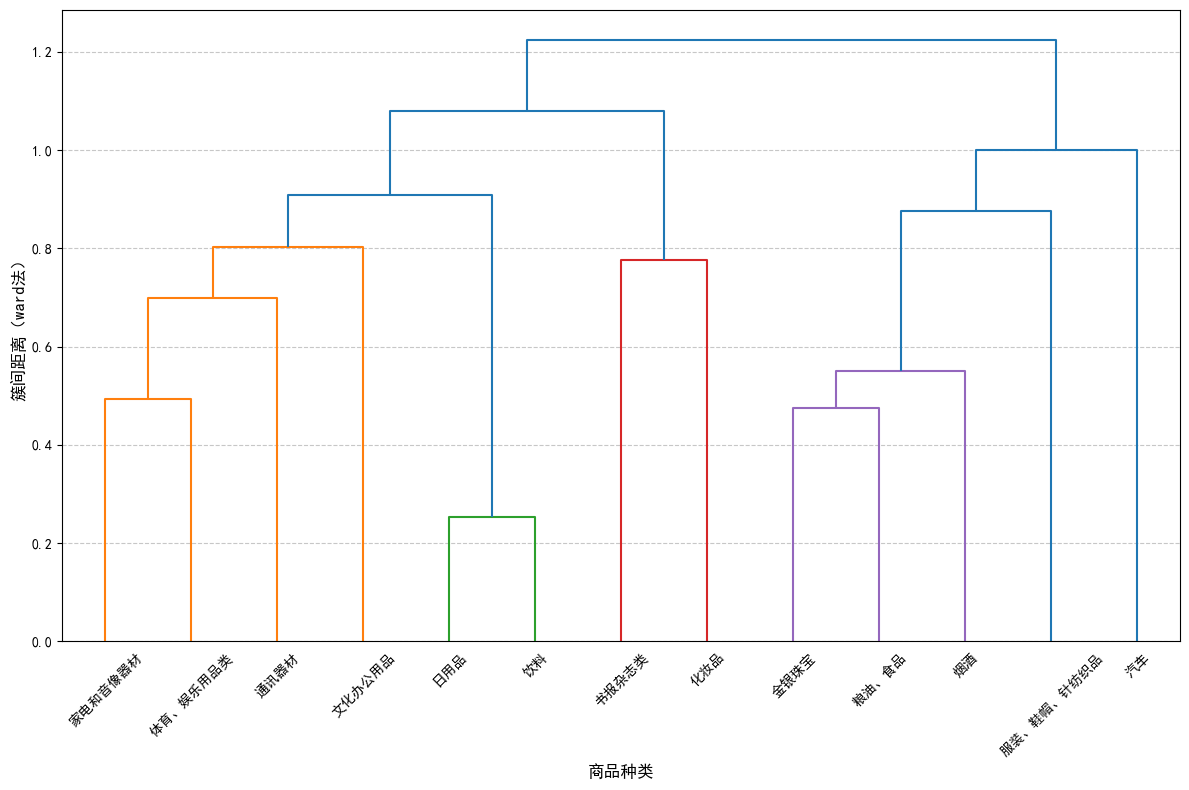

In [16]:
# 1、整理数据，只对第一大簇中的各样本进行聚类分析
df2 = df.drop(['shiyou', 'jiaju', 'zhuangxiu', 'yaopin'], axis=0)

# 2、特征标准化（关键步骤：消除量纲影响）
scaler = StandardScaler()
features_scaled2 = scaler.fit_transform(df2)  # 标准化后的特征矩阵（17×30）

# 获得17种商品类别的季节效应类型：乘法模型记为1，加法模型记为0 并加到特征矩阵中
seasonal_type = []
for i in data_dict:
    if data_dict[i].season_type() == 'multiplicative':
        seasonal_type.append(1)
    else:
        seasonal_type.append(0)
seasonal_type = np.array(seasonal_type)
seasonal_type = seasonal_type[:, np.newaxis]
features_scaled = np.hstack([features_scaled, seasonal_type])

# 3、执行层次聚类（核心函数：linkage）
# linkage函数：生成聚类的层次结构（簇间距离矩阵）
# 关键参数说明：
# - y：标准化后的特征矩阵（或样本间距离矩阵）
# - method：簇的链接方式（推荐ward法，最小化簇内方差，适配数值型特征）
# - metric：样本间距离度量（推荐euclidean欧氏距离，适配连续特征）
cluster_linkage = linkage(
    y=features_scaled2,
    method='average',  # 可选：single（最近邻）、complete（最远邻）、average（平均距离）、ward（最优，优先选）
    metric='cosine'  # 可选：euclidean（欧氏距离）、cosine（余弦距离，高维数据也适用）、manhattan（曼哈顿距离）
)

# 4、可视化聚类树（树状图，核心函数：dendrogram）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.figure(figsize=(12, 8));  # 设置图大小

# 定义商品标签
good_name = ['烟酒', '粮油、食品', '饮料', '化妆品', '金银珠宝', '体育、娱乐用品类', 
            '书报杂志类', '家电和音像器材', '文化办公用品', '通讯器材', 
            '日用品', '汽车', '服装、鞋帽、针纺织品']

# dendrogram函数：绘制树状图，直观展示聚类层级
dendrogram(
    Z=cluster_linkage,  # linkage输出的聚类结构
    labels=good_name,    # 样本标签（商品名称，便于识别）
    orientation='top',  # 树状图方向（top/left/right/bottom）
    distance_sort='descending',  # 按距离降序排列
    show_leaf_counts=True,       # 显示叶节点数量
    leaf_font_size=10,           # 叶节点（商品名）字体大小
    leaf_rotation=45             # 商品名旋转角度，避免重叠
);


plt.xlabel('商品种类', fontsize=12);
plt.ylabel('簇间距离（ward法）', fontsize=12);
plt.grid(axis='y', linestyle='--', alpha=0.7);
plt.tight_layout(); # 自动调整布局
plt.savefig("商品种类层次聚类树状图2.png", dpi=300);
plt.show();

In [17]:
# 5、确定最终聚类结果（核心函数：fcluster）
# fcluster函数：根据树状图，按指定规则划分簇
# 关键参数说明：
# - Z：linkage输出的聚类结构
# - t：簇的划分阈值（可通过树状图的纵向距离确定，或指定簇数）
# - criterion：划分规则（'maxclust'=指定簇数；'distance'=指定距离阈值）
# 方式：指定簇数
n_clusters = 2
cluster_labels2 = fcluster(
    Z=cluster_linkage,
    t=n_clusters,
    criterion='maxclust'  # 按簇数划分
)

# 6、整理聚类结果
df2['聚类标签'] = cluster_labels2
print("商品种类层次聚类结果：")
print(df2[['聚类标签']])  # 展示每个商品对应的簇标签
print(f"\n最终聚类数量：{n_clusters}")
print(f"\n各簇商品数量：")
print(df2['聚类标签'].value_counts().sort_index())

商品种类层次聚类结果：
           聚类标签
yanjiu        1
liangyou      1
yinliao       2
huazhuang     2
zhubao        1
qiuqi         2
shu           2
jiadian       2
wenju         2
tongxun       2
riyong        2
qiche         1
yifu          1

最终聚类数量：2

各簇商品数量：
聚类标签
1    5
2    8
Name: count, dtype: int64


#### **K-means交叉验证**

In [18]:
# 1、选择待验证的簇数K（比如K=3）
k = 2

# 2、初始化留一法交叉验证
loo = LeaveOneOut()
sil_scores = []  # 存储每折的轮廓系数

# 4、迭代训练
for train_idx, val_idx in loo.split(features_scaled2):
    X_train, X_val = features_scaled2[train_idx], features_scaled2[val_idx]
    
    # 用训练集训练K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    # 合并训练集和验证集，计算整体轮廓系数（评估一致性）
    X_combined = np.vstack([X_train, X_val])
    labels_combined = np.hstack([kmeans.labels_, kmeans.predict(X_val)])
    sil_score = silhouette_score(X_combined, labels_combined)
    sil_scores.append(sil_score)

# 5、结果分析
mean_sil = np.mean(sil_scores)
std_sil = np.std(sil_scores)
print(f"簇数K={k}时，交叉验证轮廓系数均值：{mean_sil:.3f}，标准差：{std_sil:.3f}")

簇数K=2时，交叉验证轮廓系数均值：0.409，标准差：0.075


### **3、零售额序列季节指数图**

In [19]:
# 1、整理序列的季节指数图
data_season = [] 
for i in range(3):
    data_season.append(pd.DataFrame(index=[i for i in range(1, 13)]))
    data_season[i].index.name = 'month'

# 乘法模型的商品簇中的两类
multi1 = ['yanjiu', 'zhubao', 'yifu', 'liangyou', 'qiche']

for i in data_dict:
    if data_dict[i].season_type() == 'multiplicative':
        if i in multi1:
            data_season[0][i] = data_dict[i].X11_seasonal_decompose()
        else:
            data_season[1][i] = data_dict[i].X11_seasonal_decompose()
    else:
        data_season[2][i] = data_dict[i].X11_seasonal_decompose()

# 将宽格式数据变为长格式
melt_ds = []
for i in range(3):
    melt_ds.append(pd.melt(data_season[i], ignore_index=False, var_name='type', value_name='value'))
   
# 设置图例文本
# 按照每一簇中，类别的字母顺序的排序位置，设置图例文本
labels = []
labels0 = ['粮油食品', '汽车', '烟酒', '服装鞋帽针纺织品', '饮料', '金银珠宝']
labels.append(labels0)
labels1 = ['化妆品', '家电和音像器材', '体育、娱乐用品', '日用品',  '书报杂志', '通讯器材', '文化办公用品', '饮料']
labels.append(labels1)
labels2 = ['家具', '中西药品', '石油及制品', '建筑及装潢材料']
labels.append(labels2)

base_plots = []

for i in range(3):
    base_plot = (ggplot(melt_ds[i], aes(x=melt_ds[i].index, y='value', group='type', color='type'))+
            geom_line(size=1)+
            geom_point(size=0.8)+
            scale_x_discrete(
                name='月份',  # X 轴标题
                limits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                labels=['1', '2', '3', '4',
                       '5', '6', '7', '8',
                       '9', '10', '11', '12']  
            )+
            scale_color_discrete(labels=labels[i])+
            xlab('月份')+
            ylab('季节指数')+
            labs(color='商品种类')+
            theme(
                text=element_text(family='SimHei'),
                axis_text_x=element_text(
                    ha='right',        # 文字右对齐（旋转后更美观）
                    color='black',   # 刻度文字颜色
                    size=10),           # 文字大小
                axis_ticks_major_x=element_line(  # X轴刻度线样式
                    color='gray',
                    size=0.8),
                # 背景设为白色
                panel_background=element_rect(fill='white', color='white'),
        
                # 主网格线：浅灰色虚线
                panel_grid_major=element_line(
                    color='#E0E0E0',  # 浅灰色
                    linetype='dashed',  # 虚线
                    size=0.8),
        
                # 次网格线（可选，更浅的虚线）
                panel_grid_minor=element_line(
                    color='#F0F0F0',
                    linetype='dashed',
                    size=0.5),
            ))
    base_plots.append(base_plot)

base_plots[0].save('商品序列季节指数图1.png', dpi=300)
base_plots[1].save('商品序列季节指数图2.png', dpi=300)
base_plots[2].save('商品序列季节指数图3.png', dpi=300)


### **4、展示17种商品零售额序列的因素分解模型差别**

In [30]:
change = np.array(change)

In [31]:
1 - change

array([0.99999995, 0.99999999, 0.99999995, 0.99999998, 0.99999994,
       0.99999987, 0.99999985, 0.99999946, 0.99999981, 0.99999979,
       0.99999447, 0.99999998, 0.99999855, 0.9999936 , 0.99999632,
       0.99999998, 0.99999995])

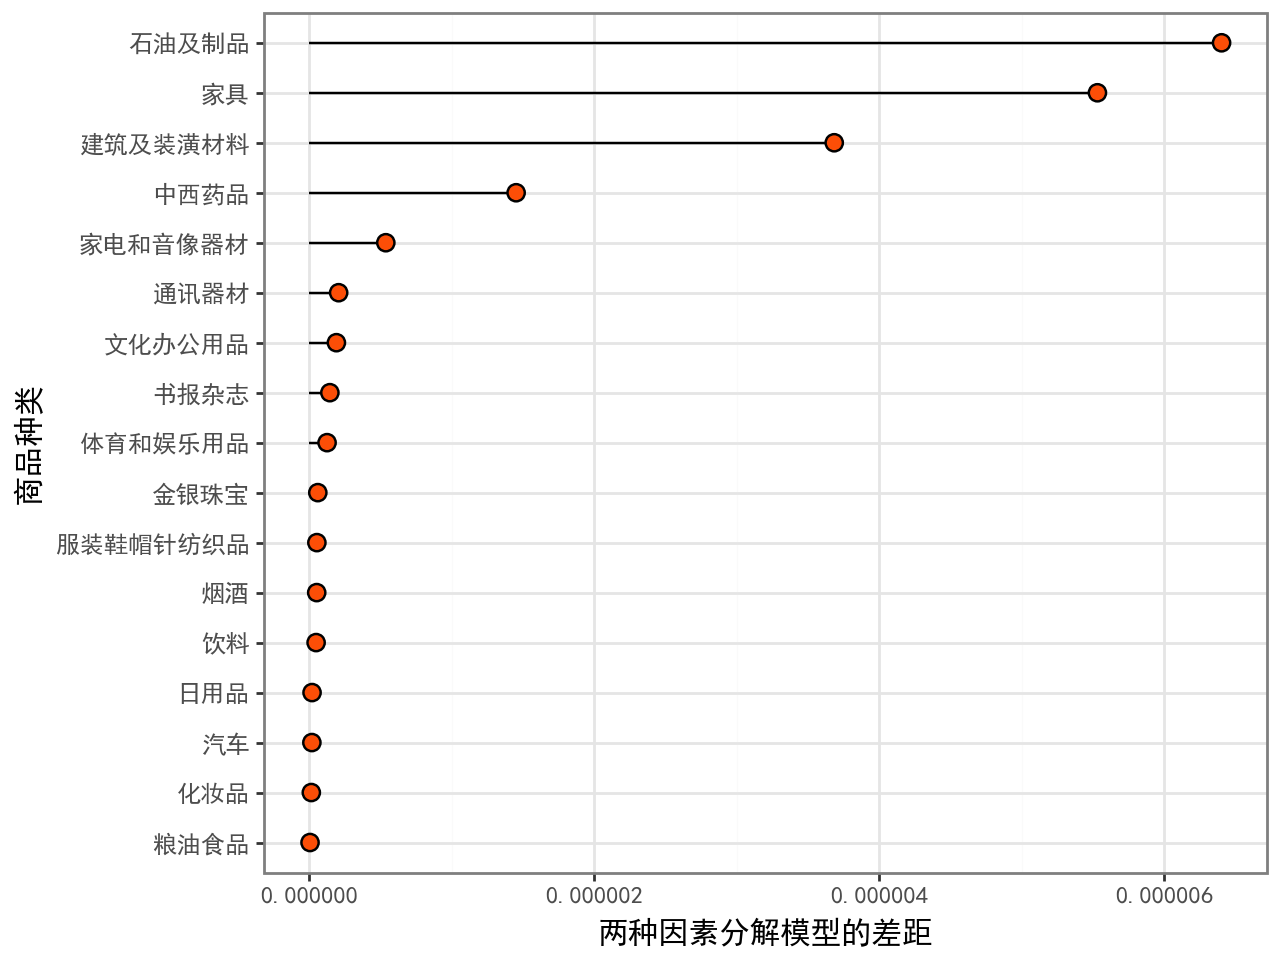

In [35]:
# 1、整理序列的因素分解模型差别
Type = []
change = []  # 衡量的是两个向量夹角的余弦值
for i in data_dict:
    Type.append(i)
    change.append(data_dict[i].change())

# 把type中的元素转写为中文表示
Type = ['烟酒', '粮油食品', '饮料', '化妆品', '金银珠宝', '体育和娱乐用品', '书报杂志', '家电和音像器材',
       '文化办公用品', '通讯器材', '家具', '日用品', '中西药品', '石油及制品', '建筑及装潢材料',
       '汽车', '服装鞋帽针纺织品']

data_change = pd.DataFrame({'type': Type, 'change':change})

# 2、绘制棒棒糖图
# 整理数据
data_change = data_change.sort_values(by='change', ascending=True)
data_change['type'] = pd.Categorical(
    data_change['type'],
    categories=data_change['type'],
    ordered=True)


change_plot = (ggplot(data_change, aes('change', 'type'))+
               geom_segment(aes(x=0, xend='change', y='type', yend='type'))+
               geom_point(shape='o', size=3, color='black', fill='#FC4E07')+
               labs(
                   x='两种因素分解模型的差距',
                   y='商品种类'
               )+
               theme_bw()+
               theme(
                text=element_text(family='SimHei')
            ))

change_plot.save('两种因素分解模型的差距.png', dpi=300)
change_plot

### **5、展示17种商品零售额序列的累计增长量**

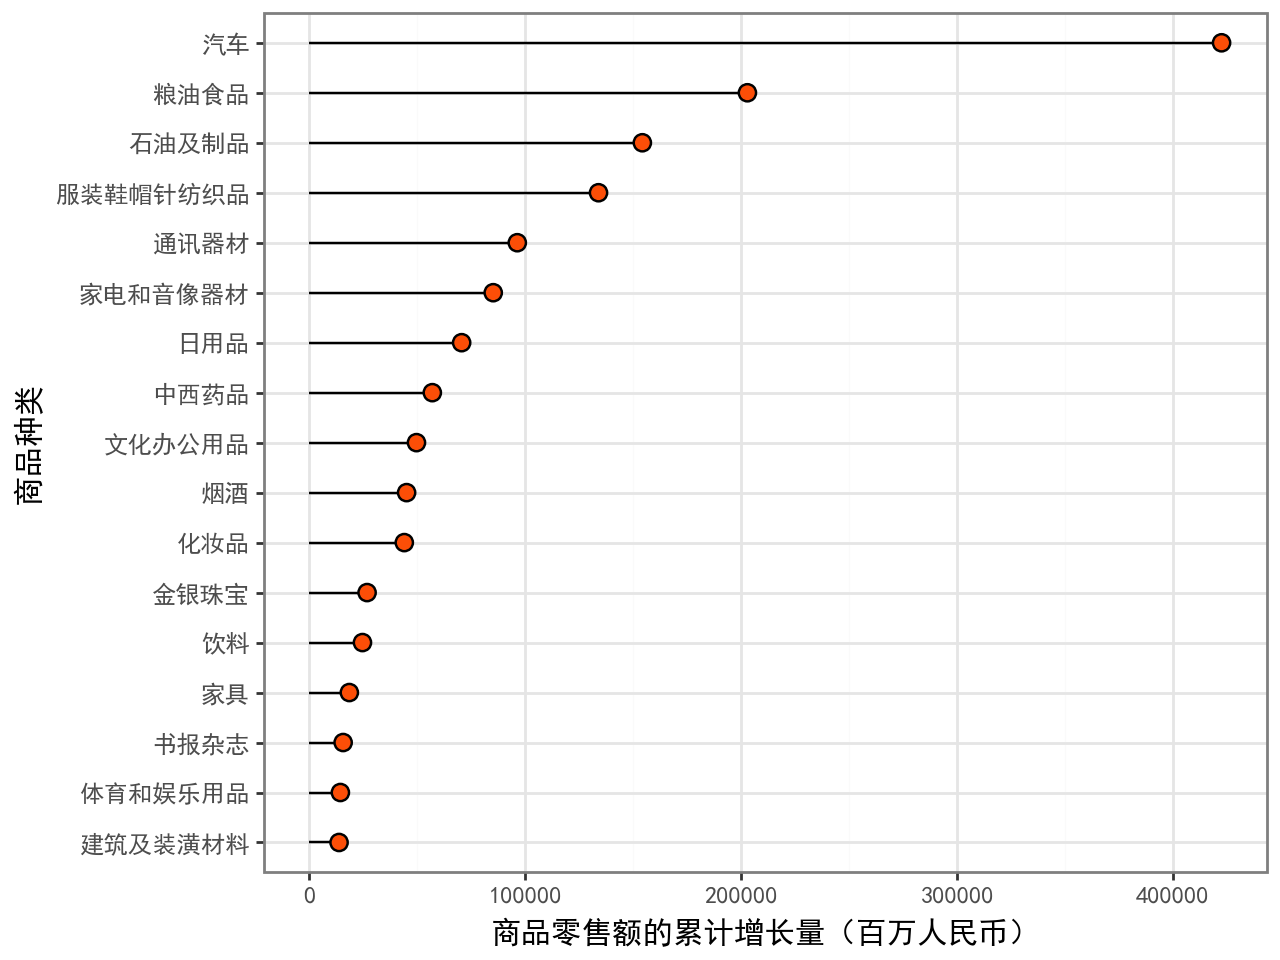

In [21]:
# 1、整理序列的累计增长量
Type = []
cumulative = []
for i in data_dict:
    Type.append(i)
    cumulative.append(data_dict[i].cumulative_growth())

# 把type中的元素转写为中文表示
Type = ['烟酒', '粮油食品', '饮料', '化妆品', '金银珠宝', '体育和娱乐用品', '书报杂志', '家电和音像器材',
       '文化办公用品', '通讯器材', '家具', '日用品', '中西药品', '石油及制品', '建筑及装潢材料',
       '汽车', '服装鞋帽针纺织品']

data_cumulative = pd.DataFrame({'type': Type, 'cumulative':cumulative})

# 2、绘制棒棒糖图
# 整理数据
data_cumulative = data_cumulative.sort_values(by='cumulative', ascending=True)


data_cumulative['type'] = pd.Categorical(
    data_cumulative['type'],
    categories=data_cumulative['type'],
    ordered=True)

cumulative_plot = (ggplot(data_cumulative, aes('cumulative', 'type'))+
               geom_segment(aes(x=0, xend='cumulative', y='type', yend='type'))+
               geom_point(shape='o', size=3, color='black', fill='#FC4E07')+
               labs(
                   x='商品零售额的累计增长量（百万人民币）',
                   y='商品种类'
               )+
               theme_bw()+
               theme(
                text=element_text(family='SimHei')
            ))

cumulative_plot.save('商品零售额的累计增长量.png', dpi=300)
cumulative_plot

### **6、展示17种商品零售额序列的平均增长率**

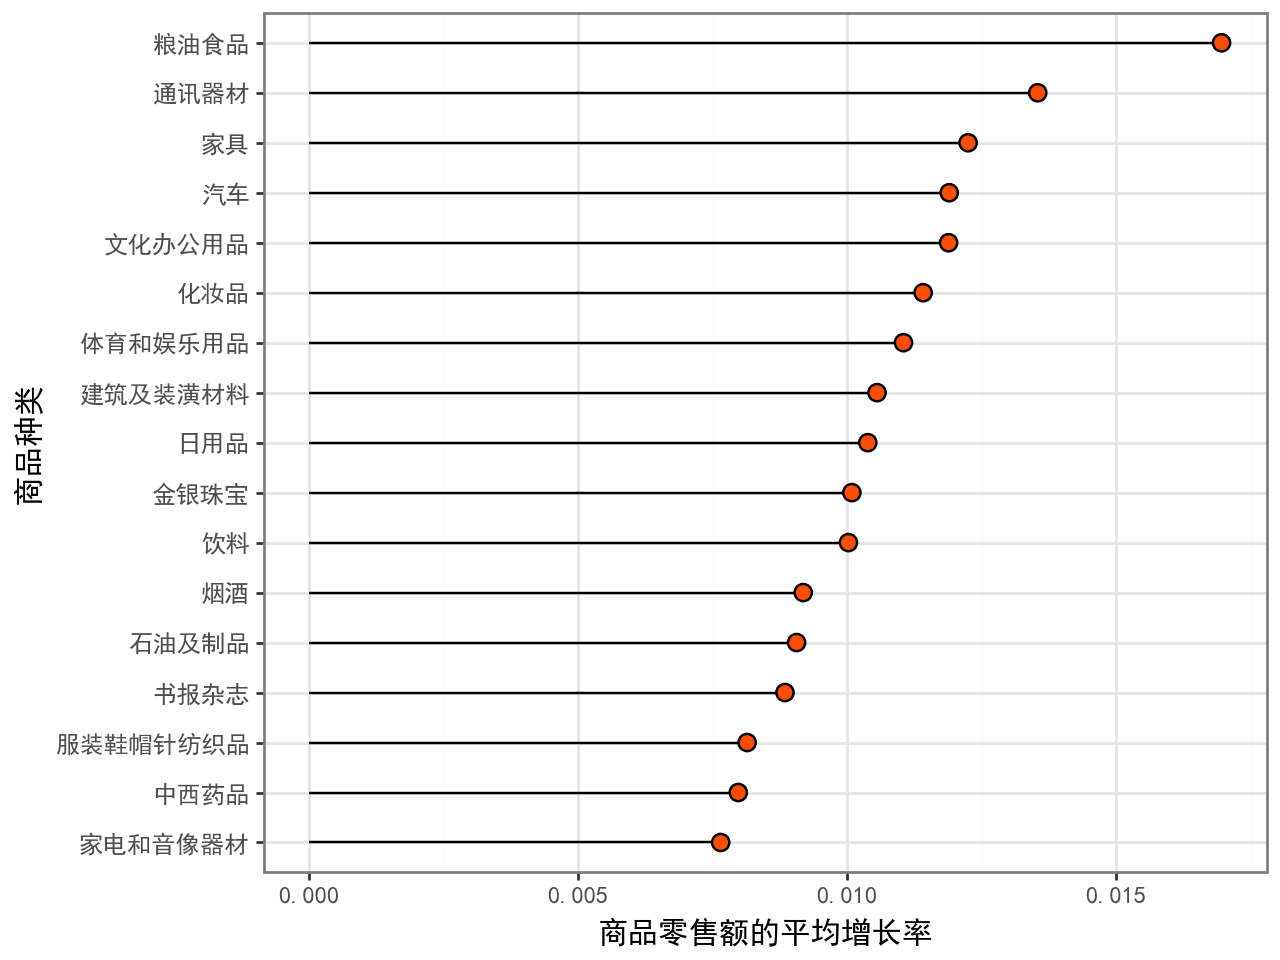

In [22]:
# 1、整理序列的平均增长率
Type = []
growth = []
for i in data_dict:
    Type.append(i)
    growth.append(data_dict[i].average_growth_rate())

# 把type中的元素转写为中文表示
Type = ['烟酒', '粮油食品', '饮料', '化妆品', '金银珠宝', '体育和娱乐用品', '书报杂志', '家电和音像器材',
       '文化办公用品', '通讯器材', '家具', '日用品', '中西药品', '石油及制品', '建筑及装潢材料',
       '汽车', '服装鞋帽针纺织品']

data_growth = pd.DataFrame({'type': Type, 'growth':growth})

# 2、绘制棒棒糖图
# 整理数据
data_growth = data_growth.sort_values(by='growth', ascending=True)


data_growth['type'] = pd.Categorical(
    data_growth['type'],
    categories=data_growth['type'],
    ordered=True)

growth_plot = (ggplot(data_growth, aes('growth', 'type'))+
               geom_segment(aes(x=0, xend='growth', y='type', yend='type'))+
               geom_point(shape='o', size=3, color='black', fill='#FC4E07')+
               labs(
                   x='商品零售额的平均增长率',
                   y='商品种类'
               )+
               theme_bw()+
               theme(
                text=element_text(family='SimHei')
            ))

growth_plot.save('商品零售额的平均增长率.png', dpi=300)
growth_plot

### **7、收集17种商品的Holt-winters三参数指数平滑模型的平滑系数**

In [23]:
alpha = []
beta = []
gamma = []
Type = ['烟酒', '粮油食品', '饮料', '化妆品', '金银珠宝', '体育和娱乐用品', '书报杂志', '家电和音像器材',
       '文化办公用品', '通讯器材', '家具', '日用品', '中西药品', '石油及制品', '建筑及装潢材料',
       '汽车', '服装鞋帽针纺织品']
for i in data_dict:
    data_dict[i].holt_winters()
    alpha.append(data_dict[i].hwlevel)
    beta.append(data_dict[i].hwtrend)
    gamma.append(data_dict[i].hwseasonal)

data_hw = pd.DataFrame({'type': Type, 'alpha': alpha, 'beta': beta, 'gamma': gamma})

In [36]:
data_hw

,type,alpha,beta,gamma
0,烟酒,0.382195,0.020577,5.338277e-01
1,粮油食品,0.429286,0.000100,5.435374e-01
2,饮料,0.368964,0.058089,6.064978e-01
3,化妆品,0.105138,0.048231,8.197442e-01
4,金银珠宝,0.335009,0.005228,4.931765e-01
5,体育和娱乐用品,0.323214,0.020201,6.767858e-01
6,书报杂志,0.146429,0.026623,6.237637e-01
7,家电和音像器材,0.323214,0.020201,6.473602e-01
8,文化办公用品,0.307806,0.007751,6.464425e-01
9,通讯器材,0.252500,0.036071,6.578000e-01


### **8、画出17种商品序列的趋势效应效果图**

In [24]:
# 制作中英文商品名字的对照
label_dict = {}
for i in range(17):
    key = list(data_dict.keys())[i]
    label_dict[key] = Type[i]

# 定义字典存储三类商品簇，分别是第一簇与第二簇（4个），第三簇的第一类（5个），第三簇的第二类（8个）
data_trend = {}
for i in range(3):
    data_trend[i] = []

for i in data_dict:
    if data_dict[i].season_type() == 'multiplicative':
        if i in multi1:
            data_trend[0].append(i)
        else:
            data_trend[1].append(i)
    else:
        data_trend[2].append(i)


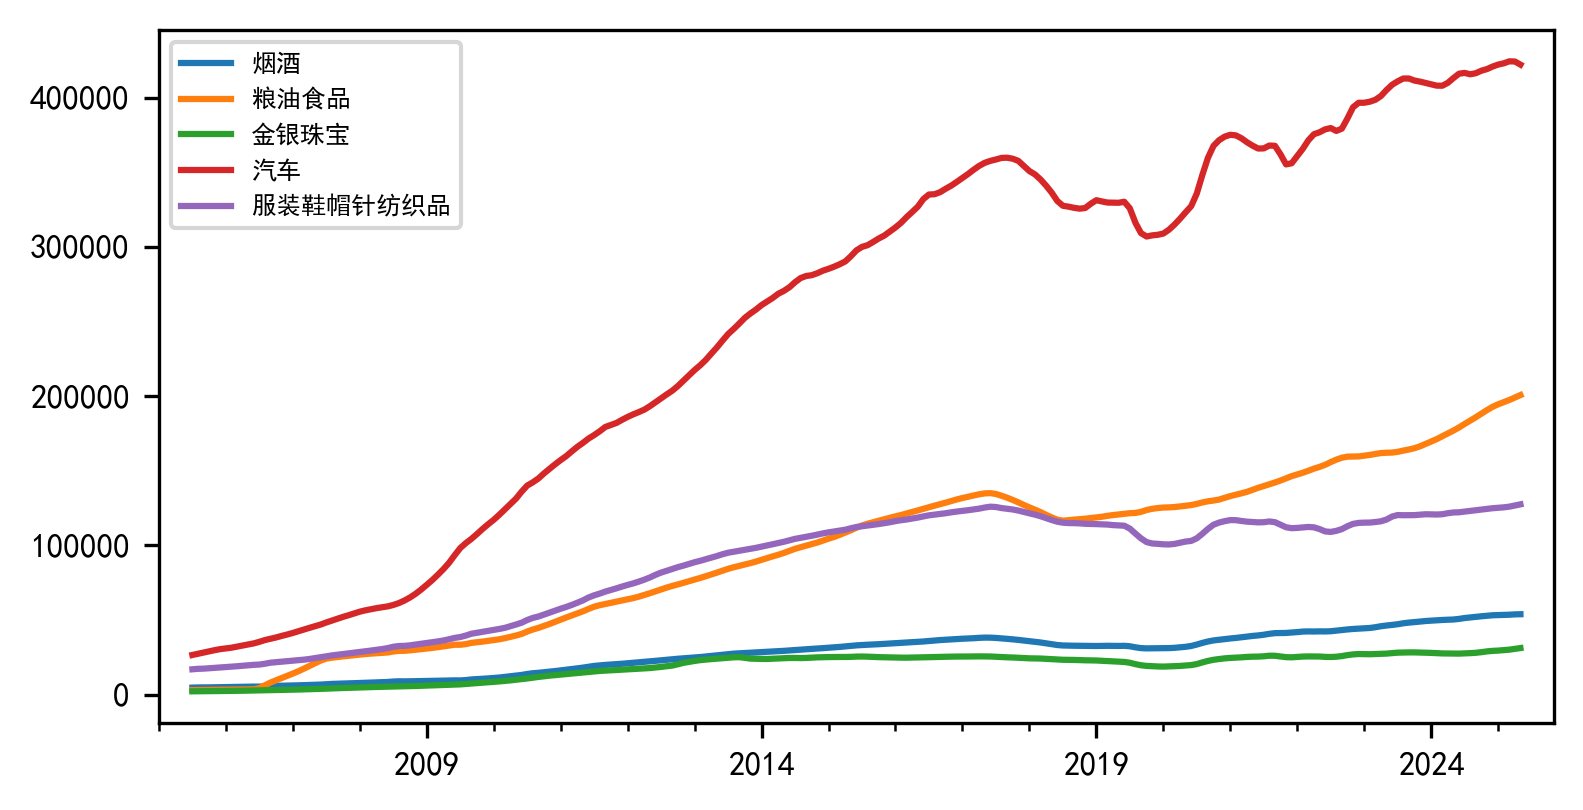

In [25]:
# 画图：第三簇的第一类（5个）
plt.figure(figsize=(6,3), dpi=300)
for i in data_trend[0]:
    data_dict[i].X11_trend_decompose().plot(label=label_dict[i]);
plt.xlabel("", fontsize=10);
plt.tick_params(labelsize=8)
plt.legend(fontsize=6);
plt.savefig('趋势效应图1.png', dpi=300)

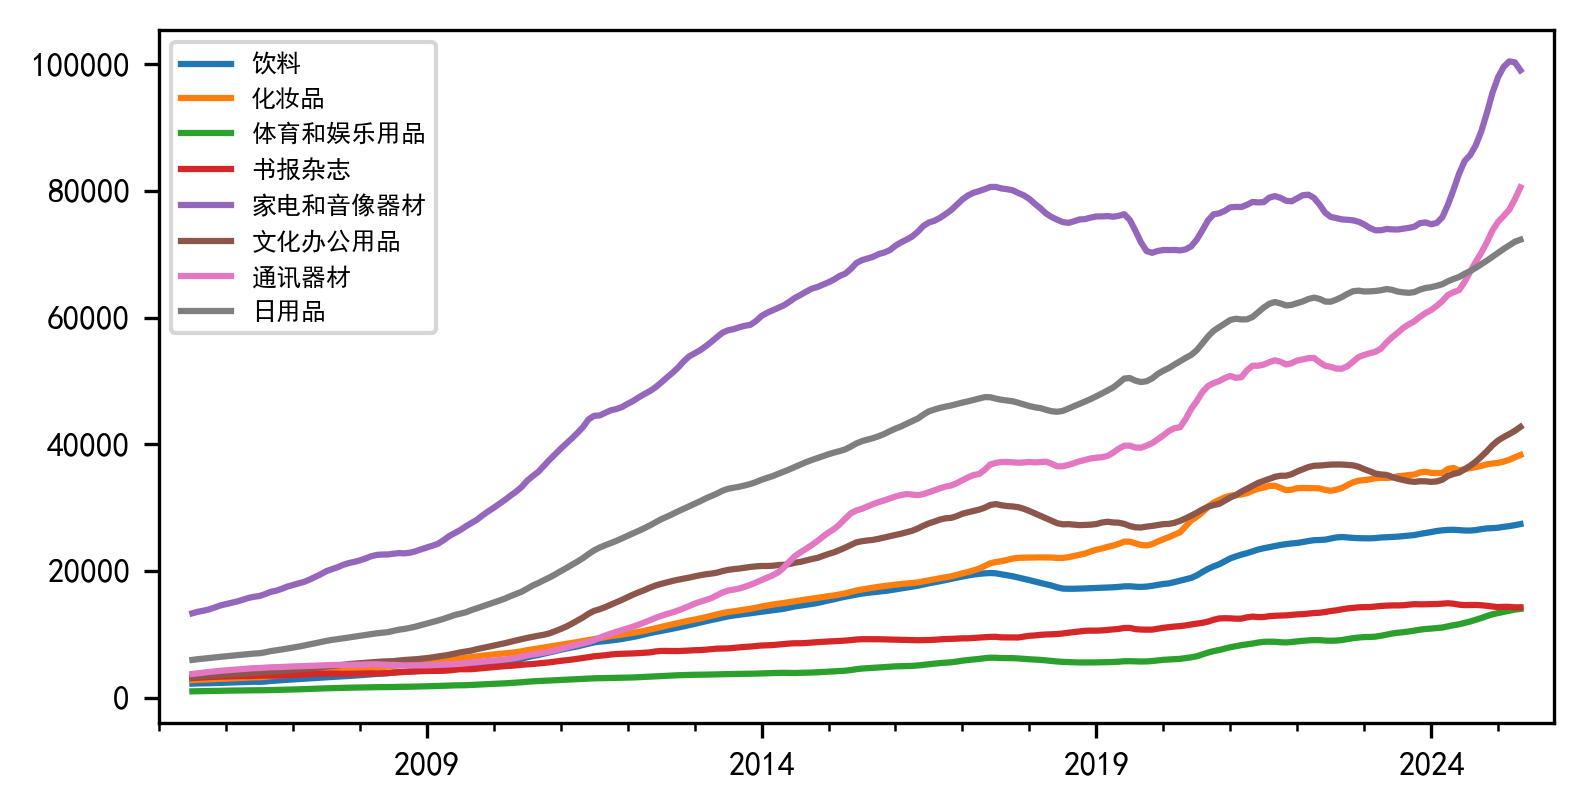

In [26]:
# 画图：第三簇的第二类（8个）
plt.figure(figsize=(6,3), dpi=300)
for i in data_trend[1]:
    data_dict[i].X11_trend_decompose().plot(label=label_dict[i]);
plt.xlabel("", fontsize=10);
plt.tick_params(labelsize=8)
plt.legend(fontsize=6);
plt.savefig('趋势效应图2.png', dpi=300)

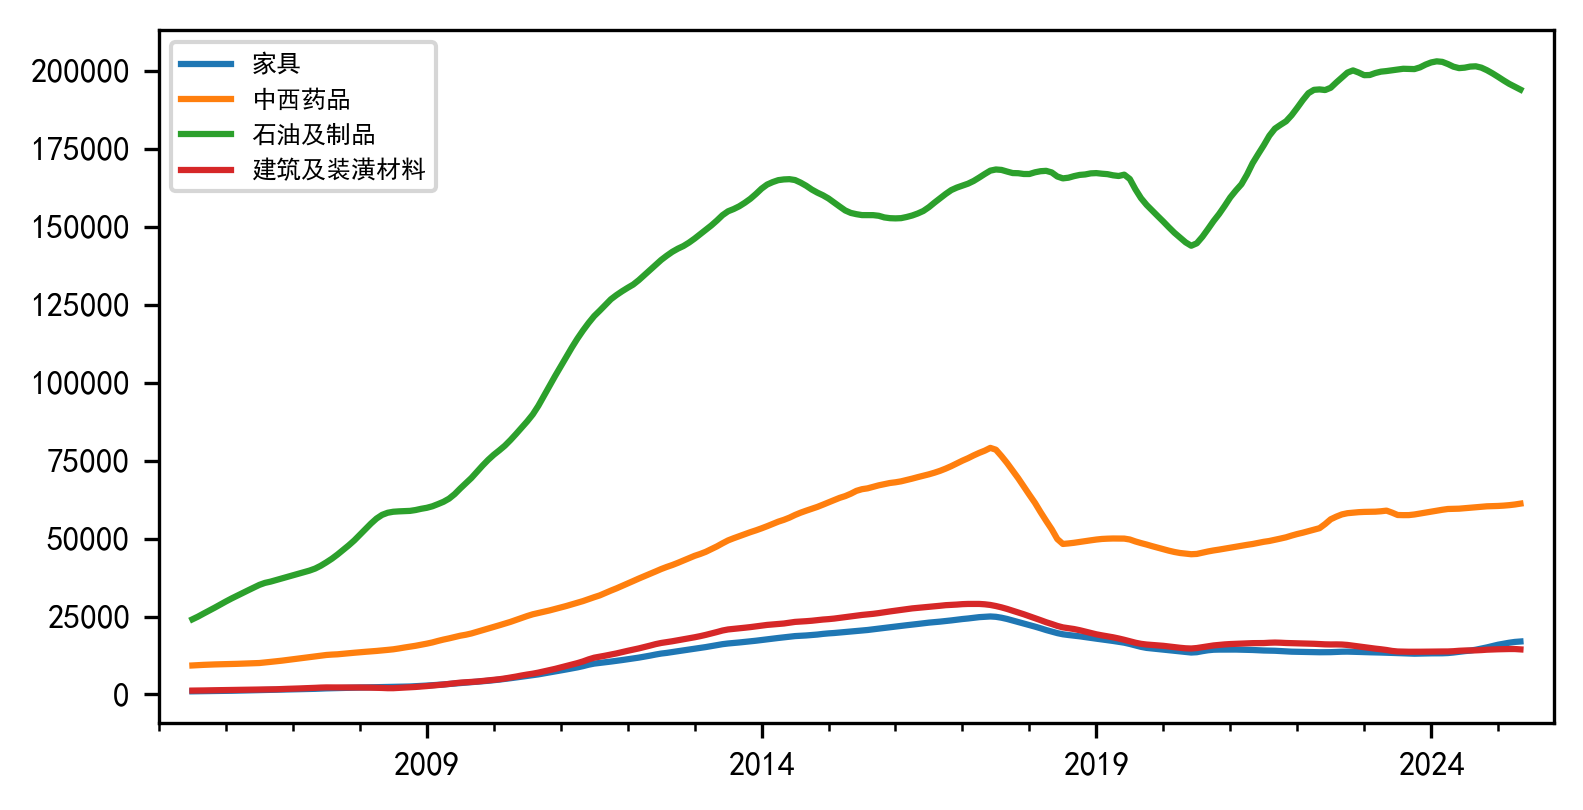

In [27]:
# 画图：第一簇与第二簇（4个）
plt.figure(figsize=(6,3), dpi=300)
for i in data_trend[2]:
    data_dict[i].X11_trend_decompose().plot(label=label_dict[i]);
plt.xlabel("", fontsize=10);
plt.tick_params(labelsize=8)
plt.legend(fontsize=6);
plt.savefig('趋势效应图3.png', dpi=300)